In [3]:
# https://www.kaggle.com/nolanbconaway/pitchfork-data

# scrape from genius
# https://chrishyland.github.io/scraping-from-genius/
# https://medium.com/analytics-vidhya/how-to-scrape-song-lyrics-a-gentle-python-tutorial-5b1d4ab351d2
import sqlite3
import pandas as pd

# import data
con = sqlite3.connect('pitchfork.sqlite')
genres = pd.read_sql('SELECT * FROM genres', con)
artists = pd.read_sql('SELECT * FROM artists', con)
reviews = pd.read_sql('SELECT * FROM reviews', con)
con.close()

scores = pd.concat([reviews['reviewid'], reviews['score']], axis=1)
albums = pd.concat([reviews['reviewid'], reviews['title']], axis=1)

genre_classes = genres['genre'].unique()
#genre_classes = ['None' if v is None else v for v in genre_classes]
genre_classes = [i for i in genre_classes if i]
print(genre_classes)

# combine genres and artists
data = pd.merge(pd.merge(pd.merge(genres, albums, on = 'reviewid'), artists, on='reviewid'), scores, on='reviewid') 

# remove 'various artists'
data = data[data.artist != 'various artists']

# remove None genre
data = data.dropna()

# sort by alphabetically by artist
data = data.sort_values(by=['score'], ascending=False)

df_train = data[0:15000]
df_test = data[15000:len(data)]
print(df_train)


['electronic', 'metal', 'rock', 'rap', 'experimental', 'pop/r&b', 'folk/country', 'jazz', 'global']
       reviewid         genre  \
18203      6200          rock   
3655      19182          rock   
1015      21866       pop/r&b   
5644      17064  experimental   
11272     12852       pop/r&b   
...         ...           ...   
365       22423  folk/country   
14369     10087           rap   
910       21868          rock   
9883      13988    electronic   
16109      7505          rock   

                                                 title            artist  \
18203  crooked rain, crooked rain: la's desert origins          pavement   
3655                                        spiderland             slint   
1015                                        dirty mind            prince   
5644                          the disintegration loops  william basinski   
11272                        histoire de melody nelson  serge gainsbourg   
...                                            

In [49]:
# generate files of artist-album from each genre

# init iterator 
it_genre = {}
num_artists = 50

# initialize empty genre.txt
for genre in genre_classes:
    if genre == 'pop/r&b':
        f = open("artist_album/pop-rnb.txt", "w+")
        f.close()
        it_genre['pop-rnb'] = num_artists
    elif genre == 'folk/country':
        f = open("artist_album/folk-country.txt", "w+")
        f.close()
        it_genre['folk-country'] = num_artists
    else:
        f = open("artist_album/"+genre+".txt", "w+")
        f.close()
        it_genre[genre] = num_artists
        
it_total = sum(it_genre.values())
# fill the genre.txt with artist_albums
for i, row in enumerate(data.itertuples()):
    if sum(it_genre.values()) != 0:
        if row.genre == 'pop/r&b':
            if it_genre['pop-rnb'] != 0:
                f = open("artist_album/pop-rnb.txt", "a+")
                f.write(row.artist + "_" + row.title + ";")
                f.close()
                it_genre['pop-rnb'] -= 1
        elif row.genre == 'folk/country':
            if it_genre['folk-country'] != 0:
                f = open("artist_album/folk-country.txt", "a+")
                f.write(row.artist + "_" + row.title + ";")
                f.close()
                it_genre['folk-country'] -= 1
        else:
            if it_genre[row.genre] != 0:
                f = open("artist_album/"+row.genre+".txt", "a+")
                f.write(row.artist + "_" + row.title + ";")
                f.close()
                it_genre[row.genre] -= 1
    else:
        break

In [18]:
# read lyrics from files
import os

lyrics = []
genres = []

for filename in os.listdir('lyrics'):
    f = open(os.path.join('lyrics', filename), 'r')
    lyric = ""
    for line in f.readlines():
        #print(line)
        if line != ";\n":
            lyric += line.replace('\n','') + ' '
        else:
            lyrics.append(lyric)
            genres.append(filename[:-4])
            lyric = ""
    f.close()

In [25]:
print(lyrics[9])

ween Ocean man, take me by the hand, lead me to the land That you understand Ocean man, the voyage to the corner of the globe Is a real trip Ocean man, the crust of a tan man imbibed by the sand Soaking up the thirst of the land Ocean man, can you see through the wonder of amazement At the Oberman? Ocean man, the crust is elusive when it casts forth To the childlike man Ocean man, the sequence of a life form braised in the sand Soaking up the thirst of the land Ocean man Ocean man Ocean man Ocean man, take me by the hand, lead me to the land That you understand Ocean man, the voyage to the corner of the globe Is a real trip  Ocean man, the crust of a tan man imbibed by the sand Soaking up the thirst of the land Ocean man, can you see through the wonder of amazement At the Oberman? Ocean man, the crust is elusive when it casts forth To the childlike man Ocean man, the sequence of a life form braised in the sand Soaking up the thirst of the land Ocean man 


In [31]:
# create pandas dataframe from lryics
df_lyrics = pd.DataFrame(list(zip(lyrics, genres)), columns = ['lyric', 'genre'])

# shuffle dataframe
df_lyrics = df_lyrics.sample(frac=1)

print(df_lyrics)

df_lyrics_train = df_lyrics[0:600]
df_lyrics_test = df_lyrics[601:929]

print(df_lyrics_train)
print(df_lyrics_test)

                                                 lyric         genre
192  the pharcyde Drop! Let me freak the funk, obso...           rap
439  blue cheer Peace of mind To find is not easy W...         metal
557  animal collective Child of limousines What's t...          rock
592  circulatory system Here comes the perfect day ...          rock
848  lali puna That day I lost my head All the thin...          rock
..                                                 ...           ...
849  lali puna Quit your jobs Don't cross you finge...          rock
446  high on fire Stealing the blades from the old ...         metal
25   chavez I don't know Where I'm going But I sure...  experimental
871  the staple singers Oh, mmm.. I know a place Ai...          rock
205  lil wayne I got a story to tell, you know that...           rap

[929 rows x 2 columns]
                                                 lyric       genre
192  the pharcyde Drop! Let me freak the funk, obso...         rap
439  blue chee

In [29]:
# classifier (genre based on artist name)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

pipe = Pipeline([('vectorizer', CountVectorizer()), ('nb', MultinomialNB())])
pipe.fit(df_lyrics_train['lyric'], df_lyrics_train['genre'])
print(classification_report(y_true = df_lyrics_test['genre'], y_pred=pipe.predict(df_lyrics_test['lyric'])))

              precision    recall  f1-score   support

  electronic       0.26      0.12      0.16        52
experimental       0.29      0.11      0.16        37
folk-country       0.00      0.00      0.00         7
      global       0.00      0.00      0.00         6
        jazz       0.80      0.31      0.44        13
       metal       0.00      0.00      0.00        11
     pop-rnb       0.17      0.05      0.08        19
         rap       0.65      0.50      0.57        30
        rock       0.54      0.90      0.67       153

    accuracy                           0.51       328
   macro avg       0.30      0.22      0.23       328
weighted avg       0.43      0.51      0.43       328



/courses/TDDE16/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AxesSubplot(0.125,0.125;0.775x0.755)


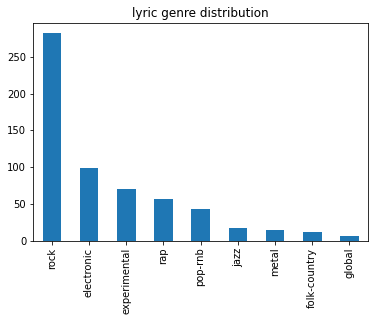

In [32]:
import matplotlib.pyplot as plt

print(df_lyrics_train['genre'].value_counts().plot(kind="bar", title="lyric genre distribution"))
